In [5]:
%pip install yfinance
%pip install matplotlib
%pip install seaborn
%pip install plotly




python(2115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(2119) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(2128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(2129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


**Import libraries**

In [6]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.tsa.stattools as ts


python(2143) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2146) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2148) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# 1. Concept

## Idea
What are our signals, why this industry, why this stocks...
## Pair Strategy
Add description of our strategy.


# 2. Data

# Retrive data

For each stock we get data from Yahoo Finance based on tickers provided in a list.

## Stock pick

We choose energy sector stocks from *S&P 500* as it is known that they have been highly correlated in the past. We picked 10 stocks with highest market cap in this sector. 

**STOCK LIST:**
- Exxon Mobil Corporation [XOM]
- Chevron Corporation [CVX]
- ConocoPhillips [COP]
- Schlumberger Limited [SLB]
- EOG Resources, Inc. [EOG]
- Marathon Petroleum Corporation [MPC]
- Phillips 66 [PSX]
- Enterprise Products Partners L.P. [EPD]
- Pioneer Natural Resources Company [PXD]
- Occidental Petroleum Corporation [OXY]




## Hourly data
We get data of our stocks as well as S&P 500 index to be able to compare returns of our strategy against a simple benchmark.

In [7]:
# Companies tickers list
ticker_list=['XOM', 'CVX', 'COP' , 'SLB', 'EOG','MPC', 'PSX', 'EPD', 'PXD', 'OXY', '^GSPC']

#get data for last 730 days on hounrly time frame
df_hourly = yf.download(ticker_list, period="730d", interval="1h")['Adj Close']

#rename sp500
df_hourly = df_hourly.rename(columns={'^GSPC':'SP500'})


[*********************100%%**********************]  11 of 11 completed


In [8]:
#check info of our data frame
df_hourly.info()
print(20*'**'+ '\n')

#count NaN values in each column
nan_counts_hourly = df_hourly.isna().sum()
display(nan_counts_hourly)
print(20*'**'+ '\n')

#let's check the index. We want date as index
df_hourly.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2021-04-12 09:30:00-04:00 to 2024-03-05 15:30:00-05:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     5094 non-null   float64
 1   CVX     5094 non-null   float64
 2   EOG     5072 non-null   float64
 3   EPD     5094 non-null   float64
 4   MPC     5094 non-null   float64
 5   OXY     5094 non-null   float64
 6   PSX     5094 non-null   float64
 7   PXD     5094 non-null   float64
 8   SLB     5024 non-null   float64
 9   XOM     5094 non-null   float64
 10  SP500   5094 non-null   float64
dtypes: float64(11)
memory usage: 477.6 KB
****************************************



Ticker
COP       0
CVX       0
EOG      22
EPD       0
MPC       0
OXY       0
PSX       0
PXD       0
SLB      70
XOM       0
SP500     0
dtype: int64

****************************************



DatetimeIndex(['2021-04-12 09:30:00-04:00', '2021-04-12 10:30:00-04:00',
               '2021-04-12 11:30:00-04:00', '2021-04-12 12:30:00-04:00',
               '2021-04-12 13:30:00-04:00', '2021-04-12 14:30:00-04:00',
               '2021-04-12 15:30:00-04:00', '2021-04-13 09:30:00-04:00',
               '2021-04-13 10:30:00-04:00', '2021-04-13 11:30:00-04:00',
               ...
               '2024-03-04 13:30:00-05:00', '2024-03-04 14:30:00-05:00',
               '2024-03-04 15:30:00-05:00', '2024-03-05 09:30:00-05:00',
               '2024-03-05 10:30:00-05:00', '2024-03-05 11:30:00-05:00',
               '2024-03-05 12:30:00-05:00', '2024-03-05 13:30:00-05:00',
               '2024-03-05 14:30:00-05:00', '2024-03-05 15:30:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=5094, freq=None)

For now, we keep data in `wide format`
- each stock is one column
- in all columns, the variable is the same: `adjusted close price`
- row index is date

In [9]:
# lets check what is maximum number of cosencutive NaN values
# If there is only a few we can decide to interpolate data with back ffill or bfill for example to get missing data

def max_consecutive_nan(column):
    max_consecutive = 0
    current_consecutive = 0

    for value in column:
        if pd.isna(value):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0

    return max_consecutive

# we apply function to each column 
max_nan_values = df_hourly.apply(max_consecutive_nan)
print(max_nan_values)

Ticker
COP      0
CVX      0
EOG      7
EPD      0
MPC      0
OXY      0
PSX      0
PXD      0
SLB      7
XOM      0
SP500    0
dtype: int64


Since there are ***max 7 consecutive NaN values*** we decide to interpolate data instead of dropping the whole series.

In [10]:
#fill missing data with last available data point before the sequence of NaN values
df_filled_hourly = df_hourly.ffill()
df_filled_hourly = df_filled_hourly.bfill()

#we make sure there is no more missing values in each of our time series (DataFrame)
missing = df_filled_hourly.isna().sum().sum()
print(f'There are {missing} missing values in our DataFrame of hourly prices.')

There are 0 missing values in our DataFrame of hourly prices.


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70 % of dataset will be used for training and remaining 30 % for testing our strategy.

In [11]:
#remove datetime index for slicing needs
df_filled_hourly = df_filled_hourly.reset_index(drop=False)

In [12]:
#split data 70/30

length = len(df_filled_hourly)

#train data is 70% of all available data
df_train_hourly = df_filled_hourly.loc[:int(length*0.7)]
df_train_hourly.to_csv('data/pair_train_h.csv')

#test data is remaining 30% of data
df_test_hourly = df_filled_hourly.loc[int(length*0.7+1):]
df_test_hourly.to_csv('data/pair_test_h.csv')

In [13]:
#check if data is continous without dropped rows (check if index is correct)
display(df_train_hourly.tail(1))
display(df_test_hourly.head())


Ticker                  Datetime      COP         CVX         EOG        EPD  \
3565   2023-04-20 12:30:00-04:00  103.375  169.789993  117.580002  26.617001   

Ticker         MPC        OXY         PSX         PXD        SLB         XOM  \
3565    125.529999  61.860001  101.169998  225.029495  52.060001  114.915001   

Ticker        SP500  
3565    4147.089844

Ticker                  Datetime         COP         CVX         EOG  \
3566   2023-04-20 13:30:00-04:00  103.410004  169.860001  117.599998   
3567   2023-04-20 14:30:00-04:00  103.099998  168.945007  117.184998   
3568   2023-04-20 15:30:00-04:00  103.779999  169.889999  118.300003   
3569   2023-04-21 09:30:00-04:00  103.599998  170.470001  118.239998   
3570   2023-04-21 10:30:00-04:00  102.519997  169.339996  117.160004   

Ticker        EPD         MPC        OXY         PSX         PXD        SLB  \
3566    26.625000  125.250000  61.820000  101.730003  224.559998  52.055000   
3567    26.605000  124.699997  61.520000  100.900002  223.460007  51.669998   
3568    26.690001  125.660004  62.040001  101.269997  225.320007  51.980000   
3569    26.760000  125.820000  62.314999  101.714996  225.509995  50.520000   
3570    26.639999  124.379997  61.724998  100.610001  223.899994  49.320099   

Ticker         XOM        SP500  
3566    115.095001  4135.759766  
3567    114.614998  4115.160156  
3568    115.639999  4130.209961  
3569    116.720001  4132.399902  
3570    116.000000  4124.629883

# Daily data

In [14]:
# Set analyzed period
start_date="2000-01-01"
end_date="2023-12-31"

#get data from yahoo finance
df_daily = yf.download(ticker_list, start=start_date, end=end_date, interval="1d")['Adj Close']

#rename sp500
df_daily = df_daily.rename(columns={'^GSPC':'SP500'})

[*********************100%%**********************]  11 of 11 completed


In [15]:
#explore dataframe
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     6037 non-null   float64
 1   CVX     6037 non-null   float64
 2   EOG     6037 non-null   float64
 3   EPD     6037 non-null   float64
 4   MPC     3150 non-null   float64
 5   OXY     6037 non-null   float64
 6   PSX     2949 non-null   float64
 7   PXD     6037 non-null   float64
 8   SLB     6037 non-null   float64
 9   XOM     6037 non-null   float64
 10  SP500   6037 non-null   float64
dtypes: float64(11)
memory usage: 566.0 KB


In [16]:
# Count NaN values in each column
nan_counts = df_daily.isna().sum()

# Display the result
print(nan_counts)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [17]:
# we apply function to each column 
max_nan_values_daily = df_daily.apply(max_consecutive_nan)
print(max_nan_values_daily)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [18]:
#Drop columns of MPC and PSX

df_daily_filtered = df_daily.drop(columns=['MPC', 'PSX'])

#reset index
df_daily_filtered=df_daily_filtered.reset_index(drop=False)


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70 % of dataset will be used for training and remaining 30 % for testing our strategy.

In [19]:
#split data 70/30

length = len(df_daily_filtered)

#train data is 70% of all available data
df_train_daily = df_daily_filtered.loc[:int(length*0.7)]
df_train_daily.to_csv('data/pair_train_daily.csv')

#test data is remaining 30% of data
df_test_daily = df_daily_filtered.loc[int(length*0.7+1):]
df_test_daily.to_csv('data/pair_test_daily.csv')

# 3. EDA

## Hourly EDA

In [20]:
# load csv of train data
df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)

#set index to date column
df_train_h.set_index('Datetime', inplace=True)

df_train_h.head()

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/112882630.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)


COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-12 09:30:00-04:00  51.849899  102.815903  71.949997  22.865999   
2021-04-12 10:30:00-04:00  51.737301  102.769997  71.639999  22.852900   
2021-04-12 11:30:00-04:00  51.419998  102.478996  71.260002  22.934999   
2021-04-12 12:30:00-04:00  51.180000  102.059998  71.019997  22.940001   
2021-04-12 13:30:00-04:00  50.959999  101.900002  70.595001  22.885000   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-12 09:30:00-04:00  53.054401  24.670000  78.930000  146.764999   
2021-04-12 10:30:00-04:00  52.829399  24.338499  78.720001  146.214996   
2021-04-12 11:30:00-04:00  52.636799  24.280001  78.389999  145.759995   
2021-04-12 12:30:00-04:00  52.490002  24.254999  78.039902  144.960007   
2021-04-12 13:30:00-04:00  52.268600  24.155001  77.680000  144.690002   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-12 09:30:00-04:00  26.740000  56.049999  4121.209961  
2021-04-12 10:30:00-04:00  26.674999  55.889999  4122.660156  
2021-04-12 11:30:00-04:00  26.625000  55.759998  4125.689941  
2021-04-12 12:30:00-04:00  26.549999  55.590000  4125.209961  
2021-04-12 13:30:00-04:00  26.455000  55.526600  4123.790039

In [21]:
fig = px.line(df_train_h, x=df_train_h.index, y=df_train_h.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig.update_layout(title='Adjusted Hourly Close Prices of Selected Stocks And S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

#show plot
fig.show()

python(2163) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [22]:
#make long format for pct_change calculation
df_long_h = pd.melt(df_train_h.reset_index(), id_vars=['Datetime'], var_name='ticker', value_name='price')

#set index again
df_long_h.set_index('Datetime', inplace=True)

#calculate pct change for each ticker
df_long_h['ret'] = df_long_h.groupby('ticker')['price'].pct_change()
df_long_h.dropna(inplace=True)


In [23]:
#calculate cumulative return
#df_long_h = df_long_h.sort_values(['Datetime', 'ticker'])
df_long_h['cum_ret'] = df_long_h.groupby('ticker')['ret'].transform(lambda x: np.cumprod(1 + x))

In [24]:
# Assuming df_long_h is your DataFrame with 'Datetime', 'ticker', and 'cumulative_return' columns
fig = px.line(df_long_h, x=df_long_h.index, y='cum_ret', color='ticker',
              title='Cumulative Returns of Selected Stocks',
              labels={'cum_ret': 'Cumulative Return', 'ticker': 'Ticker'},
              line_shape='linear')

fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


### Correlation test

In [25]:
df_train_h.head()

COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-12 09:30:00-04:00  51.849899  102.815903  71.949997  22.865999   
2021-04-12 10:30:00-04:00  51.737301  102.769997  71.639999  22.852900   
2021-04-12 11:30:00-04:00  51.419998  102.478996  71.260002  22.934999   
2021-04-12 12:30:00-04:00  51.180000  102.059998  71.019997  22.940001   
2021-04-12 13:30:00-04:00  50.959999  101.900002  70.595001  22.885000   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-12 09:30:00-04:00  53.054401  24.670000  78.930000  146.764999   
2021-04-12 10:30:00-04:00  52.829399  24.338499  78.720001  146.214996   
2021-04-12 11:30:00-04:00  52.636799  24.280001  78.389999  145.759995   
2021-04-12 12:30:00-04:00  52.490002  24.254999  78.039902  144.960007   
2021-04-12 13:30:00-04:00  52.268600  24.155001  77.680000  144.690002   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-12 09:30:00-04:00  26.740000  56.049999  4121.209961  
2021-04-12 10:30:00-04:00  26.674999  55.889999  4122.660156  
2021-04-12 11:30:00-04:00  26.625000  55.759998  4125.689941  
2021-04-12 12:30:00-04:00  26.549999  55.590000  4125.209961  
2021-04-12 13:30:00-04:00  26.455000  55.526600  4123.790039

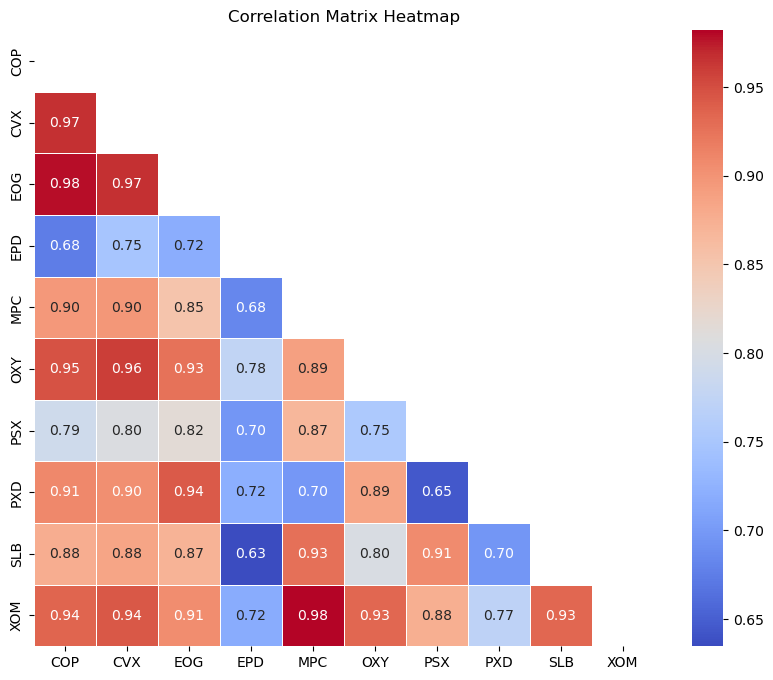

Top 5 Pairs Based on Correlation Score:
         pair  Correlation score
0  (XOM, MPC)           0.981948
1  (EOG, COP)           0.977902
2  (CVX, COP)           0.966432
3  (EOG, CVX)           0.965812
4  (OXY, CVX)           0.958905


In [26]:
#drop SP500 column for statistical tests
df_train_h_stat = df_train_h.drop(columns='SP500')

corr_matrix_hourly = df_train_h_stat.corr()

#exclude diagonal and upper triangle
np.fill_diagonal(corr_matrix_hourly.values, np.nan)
mask = np.triu(np.ones_like(corr_matrix_hourly, dtype=bool))
corr_matrix_hourly = corr_matrix_hourly.mask(mask)

# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_h = (corr_matrix_hourly.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_h['pair'] = top_pairs_cor_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Correlation Score:")
print(top_pairs_cor_h[['pair', 'Correlation score']])




### Cointegration test
We are using augmented Engle-Granger two-step cointegration test.
Testing for cointegration. We want as low p-value as possible. Ideally < 2 %.

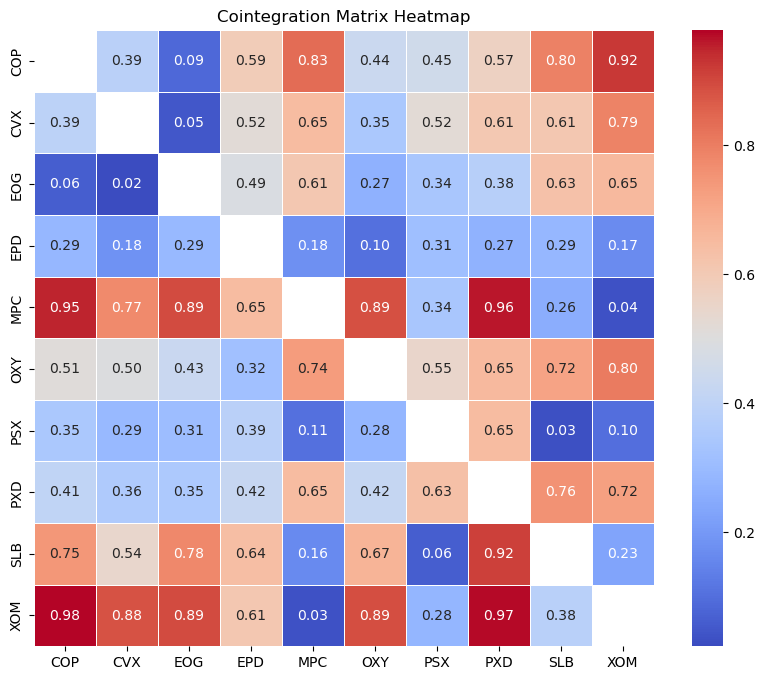

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EOG, CVX)  0.023253
1  (PSX, SLB)  0.034017
2  (XOM, MPC)  0.034631


In [27]:
columns = df_train_h_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_hourly = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_h_stat[col1], df_train_h_stat[col2])
            coint_matrix_hourly.loc[col1, col2] = p

#transform to numeric 
coint_matrix_hourly = coint_matrix_hourly.apply(pd.to_numeric, errors='coerce')


# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_h = (coint_matrix_hourly.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_h['pair'] = top_pairs_coint_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_h[['pair', 'P-value']])


In [28]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_h['pair'])
pairs_df2 = set(top_pairs_coint_h['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('EOG', 'CVX')
('XOM', 'MPC')


After comparing correlation and cointegration pair (XOM,MPC) was drop due to worse cointegration results out of those two pairs. The pair we find in both lists of top cointegrated and correlated is **(EOG,CVX)**.

### Stationarity - Augmented Dickey Fuller test

In [29]:
def stationarity_test(X, cutoff=0.02):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = round(ts.adfuller(X)[1], ndigits=4)
    if pvalue <= cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [30]:
#check for stationarity in our stocks
for ticker in df_train_h_stat.columns:
    stationarity_test(df_train_h_stat[ticker])

p-value = 0.4627 The series COP is likely non-stationary.
p-value = 0.6526 The series CVX is likely non-stationary.
p-value = 0.3531 The series EOG is likely non-stationary.
p-value = 0.1922 The series EPD is likely non-stationary.
p-value = 0.8246 The series MPC is likely non-stationary.
p-value = 0.6059 The series OXY is likely non-stationary.
p-value = 0.2807 The series PSX is likely non-stationary.
p-value = 0.3178 The series PXD is likely non-stationary.
p-value = 0.5571 The series SLB is likely non-stationary.
p-value = 0.8224 The series XOM is likely non-stationary.


Our results for stationarity are not the best, but the explenation is that our time horizon is more then 3 years and stocks rose in that time. Since our trades will be short term because of hourly time frame this is not so important and moreover we will be doing pair trading which means that pair's ratio needs to be stationary. So let's check for stationarity in our selected pair's ratio.

In [31]:
#function that creates df of ratio based on two tickers and data frame provided
#also returns graph of ration with mean value as horizontal line
def ratio_calculation_and_plot(ticker1, ticker2, df):
    ticker1 = ticker1
    ticker2 = ticker2

    #calculate ratio
    ratio = df[ticker1]/df[ticker2]
    ratio = pd.Series(ratio, name = f'Ratio {ticker1}/{ticker2}')

    #plot ratio and mean
    fig = ratio.plot(linestyle='-')
    fig.legend()
    fig.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
    return ratio, fig

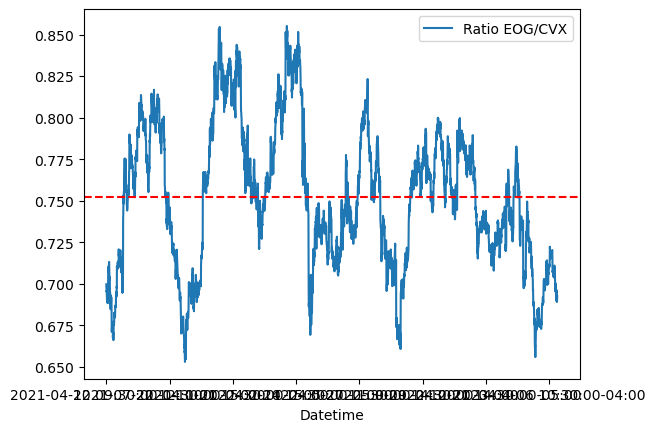

In [32]:
ratio_h, fig = ratio_calculation_and_plot('EOG','CVX',df_train_h_stat)

In [33]:
stationarity_test(ratio_h)

p-value = 0.0149 The series Ratio EOG/CVX is likely stationary.


We can say with 2 % confidence that our pair's ration EOG/CVX is stationary process.


## Daily EDA

In [34]:
# load csv of train data
df_train_d = pd.read_csv('data/pair_train_daily.csv', index_col=0, parse_dates=True)

#set index to date column
df_train_d.set_index('Date', inplace=True)

df_train_d.head()


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/506303630.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



COP        CVX       EOG       EPD       OXY       PXD  \
Date                                                                      
2000-01-03  7.988743  17.139814  2.775414  0.937858  5.084862  6.301116   
2000-01-04  7.834477  17.139814  2.775414  0.956998  4.977974  6.394464   
2000-01-05  7.691230  17.447252  2.697077  0.969758  5.008512  6.207764   
2000-01-06  7.955689  18.190235  2.920900  0.956998  5.145941  6.347787   
2000-01-07  7.955689  18.510483  2.887326  0.941048  5.298641  6.534488   

                  SLB        XOM        SP500  
Date                                           
2000-01-03  17.465256  18.328691  1455.219971  
2000-01-04  17.226826  17.977627  1399.420044  
2000-01-05  17.187088  18.957689  1402.109985  
2000-01-06  18.359385  19.937769  1403.449951  
2000-01-07  18.697161  19.879251  1441.469971

In [35]:
fig1 = px.line(df_train_d, x=df_train_d.index, y=df_train_d.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig1.update_layout(title='Adjusted Daily Close Prices of Selected Stocks and S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show the interactive plot
fig1.show()

### Correlation test

In [36]:
#make a copy of dataframe without column SP500 for statistical tests
df_train_d_stat = df_train_d.drop(columns='SP500')

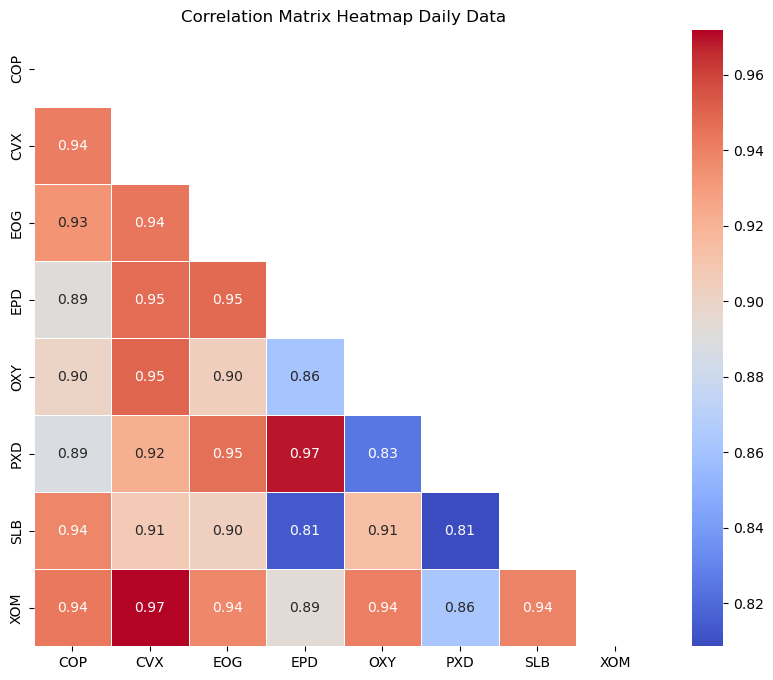

Top 5 Pairs Based on Correlation Score:
         pair  Correlation score
0  (XOM, CVX)           0.971744
1  (PXD, EPD)           0.969016
2  (OXY, CVX)           0.949692
3  (EPD, EOG)           0.948734
4  (EPD, CVX)           0.947308


In [37]:
corr_matrix_daily = df_train_d_stat.corr()


#exclude diagonal and upper triangle
mask = np.triu(np.ones_like(corr_matrix_daily, dtype=bool))
corr_matrix_daily = corr_matrix_daily.mask(mask)

# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap Daily Data')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_d = (corr_matrix_daily.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_d['pair'] = top_pairs_cor_d.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Correlation Score:")
print(top_pairs_cor_d[['pair', 'Correlation score']])

### Cointegration test

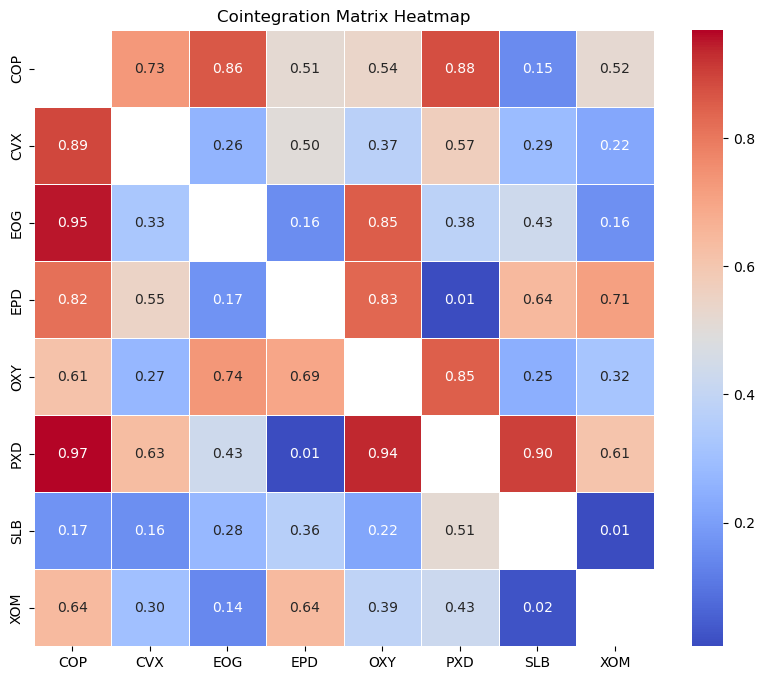

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EPD, PXD)  0.007029
1  (PXD, EPD)  0.008730
2  (SLB, XOM)  0.008824


In [38]:
columns = df_train_d_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_daily = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs (cointegration test is not a symethrical test)
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_d_stat[col1], df_train_d_stat[col2])
            coint_matrix_daily.loc[col1, col2] = p

#transform to numeric 
coint_matrix_daily = coint_matrix_daily.apply(pd.to_numeric, errors='coerce')


# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_d = (coint_matrix_daily.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_d['pair'] = top_pairs_coint_d.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_d[['pair', 'P-value']])

In [39]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_d['pair'])
pairs_df2 = set(top_pairs_coint_d['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('PXD', 'EPD')


### Stationarity - Augmented Dickey Fuller test

In [40]:
#check for stationarity in our stocks
for ticker in df_train_d_stat.columns:
    stationarity_test(df_train_d_stat[ticker])

p-value = 0.4726 The series COP is likely non-stationary.
p-value = 0.8446 The series CVX is likely non-stationary.
p-value = 0.8851 The series EOG is likely non-stationary.
p-value = 0.9224 The series EPD is likely non-stationary.
p-value = 0.6465 The series OXY is likely non-stationary.
p-value = 0.8869 The series PXD is likely non-stationary.
p-value = 0.5251 The series SLB is likely non-stationary.
p-value = 0.7925 The series XOM is likely non-stationary.


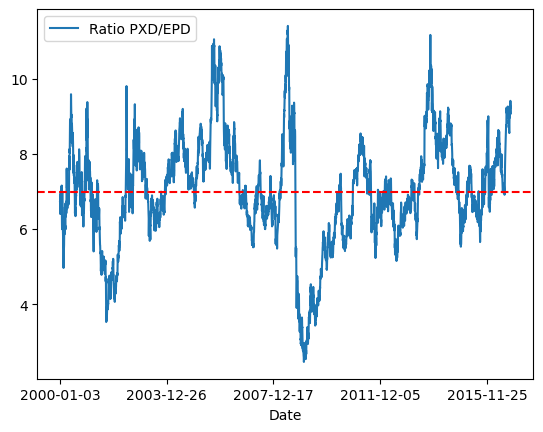

In [41]:
ratio_d, fig_d = ratio_calculation_and_plot('PXD','EPD',df_train_d_stat)

In [42]:
stationarity_test(ratio_d)

p-value = 0.0027 The series Ratio PXD/EPD is likely stationary.


# 4. Strategy

## Hourly Strategy

### Standardization: Z-score

A z-score is the number of standard deviations a data point is from the mean. More importantly, the number of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i} = \frac{x_{i} - \bar{x}}{s}$$

In [43]:
# we lag prices to avoid bias of seeing end of the day prices at the begining of the day
df_eog_cvx = df_train_h_stat[['EOG', 'CVX']].copy()

df_eog_cvx['lag_EOG'] = df_eog_cvx['EOG'].shift(1)

df_eog_cvx['lag_CVX'] = df_eog_cvx['CVX'].shift(1)
df_eog_cvx = df_eog_cvx.dropna()



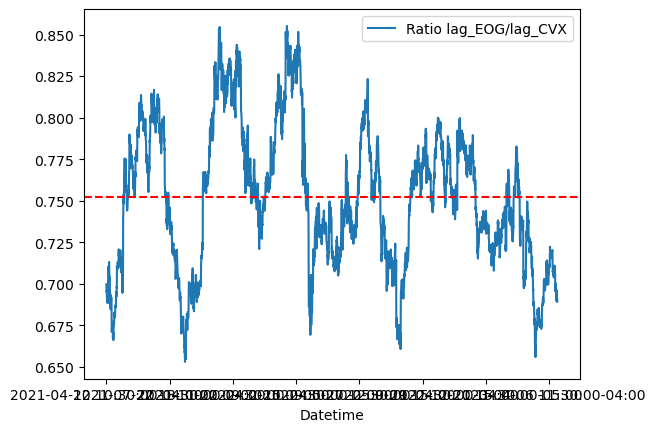

In [44]:
ratio_h_lagged,_ = ratio_d, fig_d = ratio_calculation_and_plot('lag_EOG','lag_CVX',df_eog_cvx)

In [45]:
#z score calculation
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [46]:
#z score calculation with mooving averages
def zscore_mooving(series):
    #ratios_mavg5 = series.rolling(window=5, center=False).mean()
    ratios_mavg20 = series.rolling(window=20, center=False).mean()
    std_20 = series.rolling(window=20, center=False).std()
    zscore_20 = (series - ratios_mavg20)/std_20
    return zscore_20

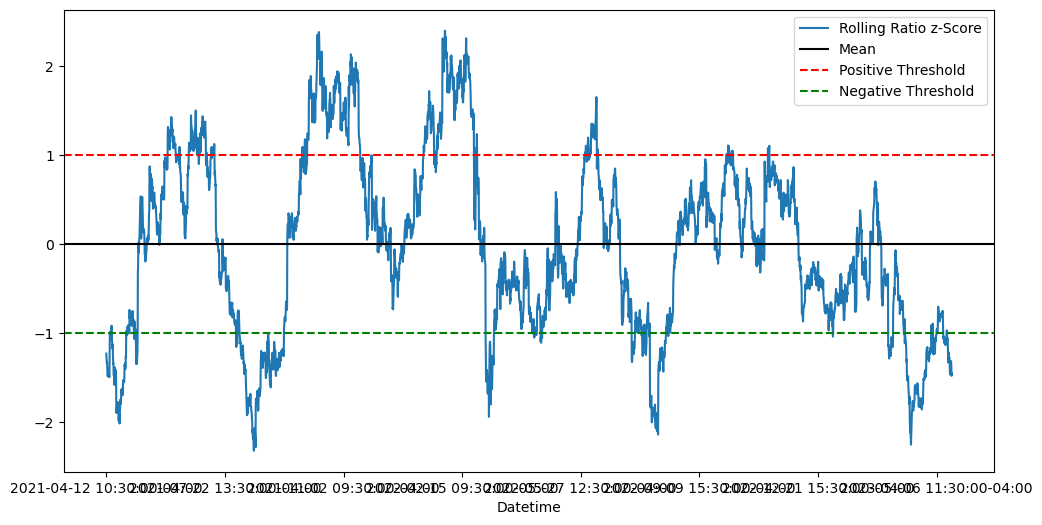

In [47]:
zscore_h = zscore(ratio_h_lagged)
zscore_h.name = f'Z-score {ratio_h.name[-7:]}'


zscore_h.plot(figsize=(12,6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean','Positive Threshold', 'Negative Threshold'])

plt.show()

In [48]:
df_ret_h = df_long_h[(df_long_h['ticker'] == "EOG")|(df_long_h['ticker'] == "CVX")]
df_ret_h = df_ret_h.drop(columns='price')

In [49]:
wide_df_h = df_ret_h.pivot(columns='ticker', values=['ret', 'cum_ret'])

# Assuming wide_df is your DataFrame with multi-level columns
wide_df_h.columns = [f'{ticker}_{col}' if col != '' else col for col, ticker in wide_df_h.columns]


In [50]:
zscore_h = pd.DataFrame(zscore_h)

#combine zscore, and prices lagged in one table
df_eog_cvx = df_eog_cvx[["lag_EOG", "lag_CVX"]]
df_strategy = pd.merge(df_eog_cvx, zscore_h, left_index=True, right_index=True)
df_strategy = pd.merge(df_strategy,wide_df_h,left_index=True, right_index=True)


In [51]:
#Betas
beta_CVX = 1.12
beta_EOG = 1.39

position_encoding = {
    0 : 'no positions',
    1 : 'long on EOG & short on CVX',
    2 : 'long on CVX & short on EOG'}


In [52]:
# This function returns the numbers of shares to trade from each company
# In this case I will fix the number of CVX's shares to 1000 and round up
#   the equivalent number of EOG's shares to the closest int. 
def get_number_of_shares(ts1, ts2, time):
  ratio = ts2[time]/ts1[time] * beta_CVX/beta_EOG
  return np.rint(1000*ratio), 1000

In [66]:
def strategy_simulation(ticker1, ticker2, df, upper_threshold, lower_threshold):
    # Portfolio value over time
    # It equals the total plus the position value
    portfolio_value = []

    # Current total
    total = 0
    current_position = 0  # Starts with no position
    
    # Number of shares
    n_EOG = 0 
    n_CVX = 0

    # Stock prices
    ts1 = df[f'lag_{ticker1}']
    ts2 = df[f'lag_{ticker2}']
    
    position_history = []
    # Strategy simulation script
    for i, z in enumerate(df_strategy[f'Z-score {ticker1}/{ticker2}']):
      # If has position check if should quit
      if current_position == 1:
        # condition to quit long EOG short CVX
        if z >= 0:
          total += ts1[i] * n_EOG
          total -= ts2[i] * n_CVX
          n_EOG = 0
          n_CVX = 0
          current_position = 0
      elif current_position == 2:
        # condition to quit long CVX short EOG
        if z <= 0:
          total -= ts1[i] * n_EOG
          total += ts2[i] * n_CVX
          n_EOG = 0
          n_CVX = 0
          current_position = 0
    
      # If has no position check if should enter
      # Note that this allows to switch positions
      if current_position == 0:
        # condition to enter long CVX short EOG
        if z >= upper_threshold:
          n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
          total += ts1[i] * n_EOG
          total -= ts2[i] * n_CVX
          current_position = 2
        # condition to enter long EOG short CVX
        elif z <= lower_threshold:
          n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
          total -= ts1[i] * n_EOG
          total += ts2[i] * n_CVX
          current_position = 1

      # Register position
      position_history.append(current_position)

      # Compute current portfolio value 
      current_portfolio_value = total
      # If long EOG short CVX
      if current_position == 1:
        current_portfolio_value += n_EOG * ts1[i]
        current_portfolio_value -= n_CVX * ts2[i]
      # If long CVX short EOG
      elif current_position == 2:
        current_portfolio_value -= n_EOG * ts1[i]
        current_portfolio_value += n_CVX * ts2[i]
      # Register current portfolio value
      portfolio_value.append(current_portfolio_value)
    current_position = 0
    total = 0

  #print('Final portfolio value: %.2F' % portfolio_value[-1])

    #create data frame of portfolio value
    df_portfolio_value = pd.DataFrame(portfolio_value, columns=['value'])
    df_position_history = pd.DataFrame(position_history, columns=['pos'])
    #print('Final portfolio value: %.2F' % portfolio_value[-1])
    portfolio_value.clear()
    return df_portfolio_value, df_position_history



In [67]:
def strategy_simulation_fees(ticker1, ticker2, df, upper_threshold, lower_threshold):
    # Portfolio value over time
    portfolio_value = []

    # Current total
    total = 0
    current_position = 0  # Starts with no position
    
    # Number of shares
    n_EOG = 0 
    n_CVX = 0

    # Stock prices
    ts1 = df[f'lag_{ticker1}']
    ts2 = df[f'lag_{ticker2}']
    
    position_history = []
    # Strategy simulation script
    for i, z in enumerate(df[f'Z-score {ticker1}/{ticker2}']):
        # If has position, check if should quit
        if current_position == 1:
            # condition to quit long EOG short CVX
            if z >= 0:
                total += ts1[i] * n_EOG * (1 - 0.001)  # 0.1% fee for long position
                total -= ts2[i] * n_CVX * (1 + 0.002)  # 0.2% fee for short position
                n_EOG = 0
                n_CVX = 0
                current_position = 0
        elif current_position == 2:
            # condition to quit long CVX short EOG
            if z <= 0:
                total -= ts1[i] * n_EOG * (1 + 0.001)  # 0.1% fee for long position
                total += ts2[i] * n_CVX * (1 - 0.002)  # 0.2% fee for short position
                n_EOG = 0
                n_CVX = 0
                current_position = 0
    
        # If has no position, check if should enter
        # Note that this allows switching positions
        if current_position == 0:
            # condition to enter long CVX short EOG
            if z >= upper_threshold:
                n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
                total += ts1[i] * n_EOG * (1 - 0.001)  # 0.1% fee for long position
                total -= ts2[i] * n_CVX * (1 + 0.002)  # 0.2% fee for short position
                current_position = 2
            # condition to enter long EOG short CVX
            elif z <= lower_threshold:
                n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
                total -= ts1[i] * n_EOG * (1 + 0.001)  # 0.1% fee for long position
                total += ts2[i] * n_CVX * (1 - 0.002)  # 0.2% fee for short position
                current_position = 1

        # Register position
        position_history.append(current_position)

        # Compute current portfolio value 
        current_portfolio_value = total
        # If long EOG short CVX
        if current_position == 1:
            current_portfolio_value += n_EOG * ts1[i] * (1 - 0.001)  # 0.1% fee for long position
            current_portfolio_value -= n_CVX * ts2[i] * (1 + 0.002)  # 0.2% fee for short position
        # If long CVX short EOG
        elif current_position == 2:
            current_portfolio_value -= n_EOG * ts1[i] * (1 + 0.001)  # 0.1% fee for long position
            current_portfolio_value += n_CVX * ts2[i] * (1 - 0.002)  # 0.2% fee for short position
            
        portfolio_value.append(current_portfolio_value)

    current_position = 0
    total = 0

    
    
    # create data frame of portfolio value
    df_portfolio_value = pd.DataFrame(portfolio_value, columns=['value'])
    df_position_history = pd.DataFrame(position_history, columns=['pos'])
    #print('Final portfolio value: %.2F' % portfolio_value[-1])
    portfolio_value.clear()
    return df_portfolio_value, df_position_history


In [68]:
# Create a sequence from -0.5 to -1.5 with step 0.1
lower_threshold = np.linspace(-0.5, -1.5, num=11)
# Create a sequence from 0.5 to 1.5 with step 0.1
upper_threshold = np.linspace(0.5, 1.5, num=11)

# create pairs: each short assign to each long
pairs = [(l, u) for l in lower_threshold for u in upper_threshold]

In [69]:
# parameters search
results = {}

# loop over pairs
for l,u in pairs:
  df_portfolio_value,_ = strategy_simulation_fees('EOG', 'CVX', df_strategy, u, l)

  final_value = df_portfolio_value['value'].iloc[-1]
  results[(l,u)] = final_value


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/1022240767.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/3907342874.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/3907342874.py:51: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykern

In [70]:
# print results
for k, v in results.items():
  print(f'{k}: {v:.4f}')

max_key = max(results, key=lambda k: results[k])
max_value = results[max_key]

print(10*'****')

print(f"Max Portfolio Value: {max_value} for parameters {max_key}")

(-0.5, 0.5): 72176.6391
(-0.5, 0.6): 72537.5510
(-0.5, 0.7): 78072.7298
(-0.5, 0.8): 78736.5805
(-0.5, 0.9): 64455.6999
(-0.5, 1.0): 65331.0110
(-0.5, 1.1): 66705.3193
(-0.5, 1.2000000000000002): 54072.9021
(-0.5, 1.3): 57007.5446
(-0.5, 1.4): 59717.1167
(-0.5, 1.5): 60815.0785
(-0.6, 0.5): 72714.2908
(-0.6, 0.6): 73075.2027
(-0.6, 0.7): 78610.3815
(-0.6, 0.8): 79274.2322
(-0.6, 0.9): 64993.3515
(-0.6, 1.0): 65868.6627
(-0.6, 1.1): 67242.9709
(-0.6, 1.2000000000000002): 54610.5538
(-0.6, 1.3): 57545.1962
(-0.6, 1.4): 60254.7684
(-0.6, 1.5): 61352.7302
(-0.7, 0.5): 68972.5892
(-0.7, 0.6): 69333.5010
(-0.7, 0.7): 74868.6798
(-0.7, 0.8): 75532.5305
(-0.7, 0.9): 61251.6499
(-0.7, 1.0): 62126.9611
(-0.7, 1.1): 63501.2693
(-0.7, 1.2000000000000002): 50868.8521
(-0.7, 1.3): 53803.4946
(-0.7, 1.4): 56513.0668
(-0.7, 1.5): 57611.0286
(-0.8, 0.5): 66800.5967
(-0.8, 0.6): 67161.5086
(-0.8, 0.7): 72696.6874
(-0.8, 0.8): 73360.5381
(-0.8, 0.9): 59079.6575
(-0.8, 1.0): 59954.9686
(-0.8, 1.1): 61329.

In [73]:
#add datetime index to our portfolio value df
df_portfolio_value_max, df_position_history_max= strategy_simulation_fees('EOG', 'CVX', df_strategy, 0.7, -1.5)
df_portfolio_value_max.index = zscore_h.index
df_position_history_max.index = zscore_h.index

df_profit_plot_h = pd.merge(df_portfolio_value_max,df_position_history_max, left_index=True, right_index=True )

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/1022240767.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/3907342874.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_785/3907342874.py:51: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykern

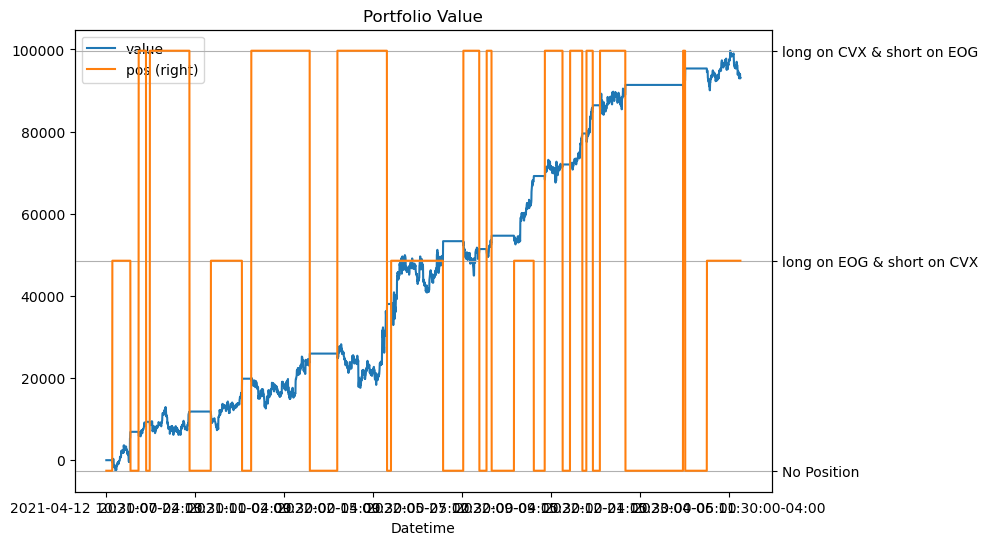

In [74]:
# Plot results
df_profit_plot_h.plot(figsize=(9, 6), secondary_y='pos', title='Portfolio Value', grid=True)

# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

plt.show()


In [75]:
df_zscore_pos = pd.merge(zscore_h, df_position_history_max, left_index=True, right_index=True)


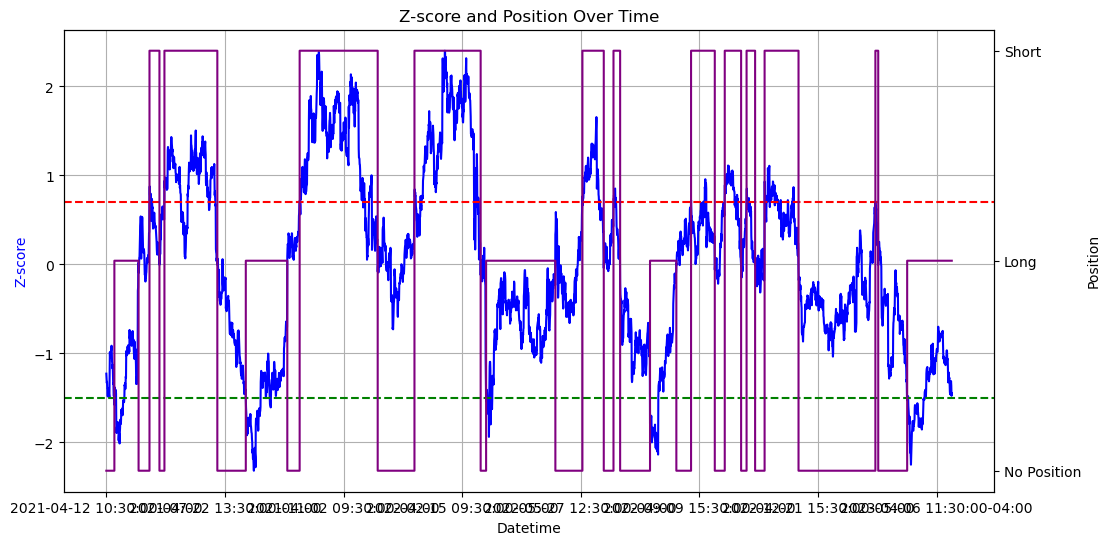

In [76]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the zscore on the primary y-axis
df_zscore_pos['Z-score EOG/CVX'].plot(ax=ax1, color='blue', label='Z-score', grid=True)
ax1.set_ylabel('Z-score', color='blue')

# Add horizontal lines to the primary y-axis
ax1.axhline(y=0.7, color='red', linestyle='--', label='Upper Threshold')
ax1.axhline(y=-1.5, color='green', linestyle='--', label='Lower Threshold')

# Overlay a secondary y-axis for position
ax2 = ax1.twinx()
ax2.step(df_zscore_pos.index, df_zscore_pos['pos'], where='post', color='purple', label='Position')

# Set y-axis ticks and labels for the secondary axis
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['No Position', 'Long', 'Short'])

ax2.set_ylabel('Position')

plt.title('Z-score and Position Over Time')
plt.show()

In [77]:
df_cvxeog = df_strategy[['lag_EOG','lag_CVX']]
df_cvxeog_pos = pd.merge(df_cvxeog, df_position_history_max, left_index=True, right_index=True)

([<matplotlib.axis.YTick at 0x171222e50>,
 [Text(1, 0, 'No Position'),
  Text(1, 1, 'long on EOG & short on CVX'),
  Text(1, 2, 'long on CVX & short on EOG')])

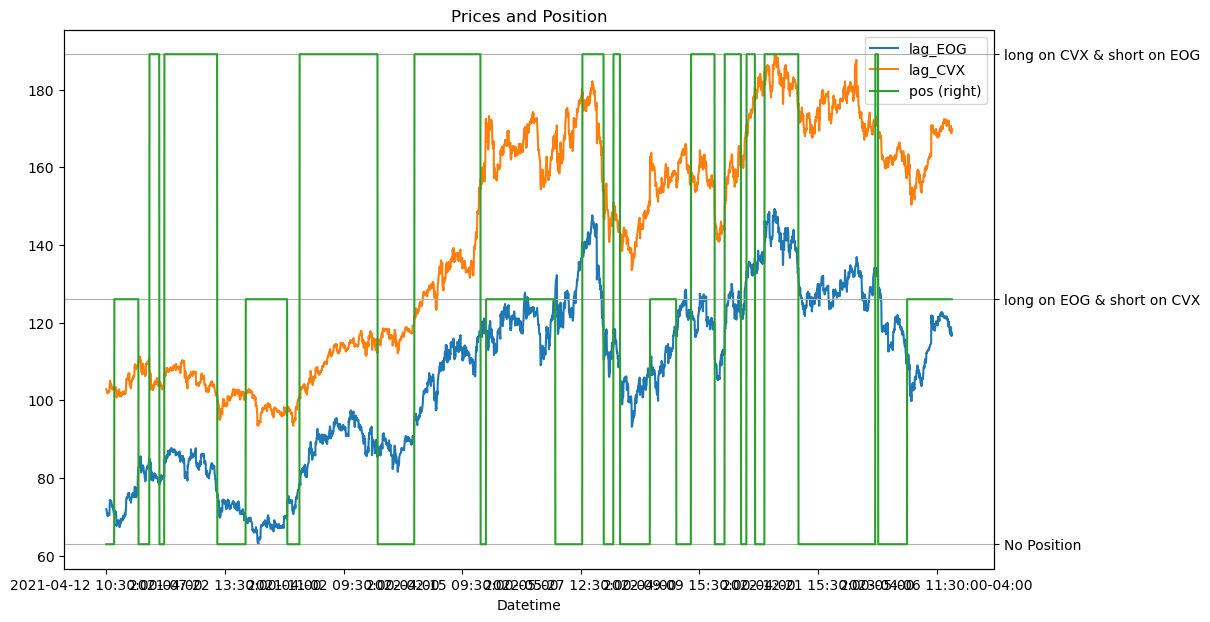

In [78]:
df_cvxeog_pos.plot(figsize=(12,7), secondary_y ='pos', title='Prices and Position', grid=True)
# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

## Daily Strategy

### Standardization: Z-score

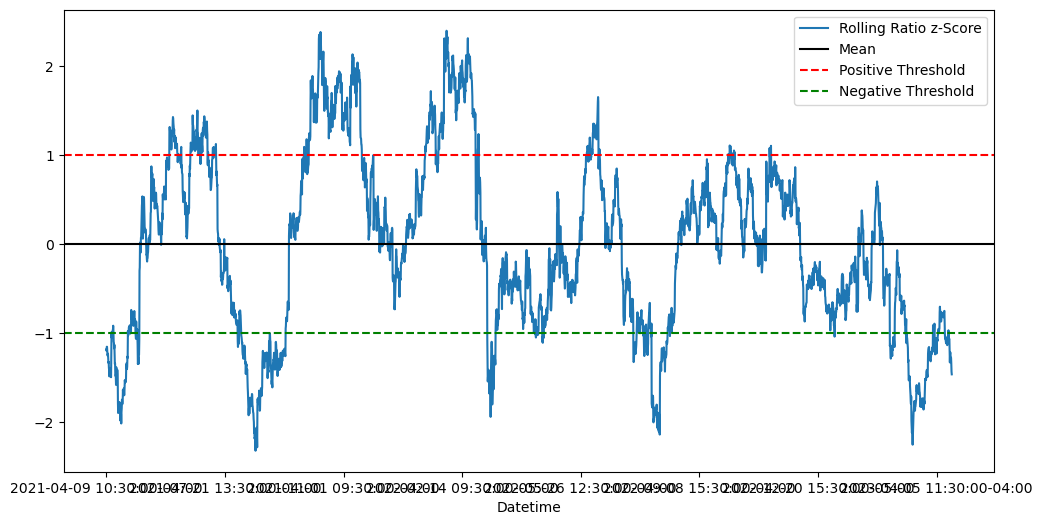

In [48]:
zscore_d = zscore(ratio_d)
zscore_d.name = f'Z-score {ratio_d.name[-7:]}'


zscore_d.plot(figsize=(12,6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean','Positive Threshold', 'Negative Threshold'])

plt.show()